### Importing Libraries

In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(12,10)})

import warnings
warnings.filterwarnings("ignore")

# for models
from sklearn.model_selection import train_test_split

# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix

In [34]:
import random
random.seed(101)

### Loading data

In [35]:
# load dataset titanic
data = sns.load_dataset('titanic')

In [36]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [38]:
dict_live = {
    0:"Died",
    1:'Survived'
}

dict_sex = {
    'male':0,
    'female':1
}

In [39]:
data['Bsex'] = data['sex'].apply(lambda x: dict_sex[x])

In [40]:
# features
features = data[['pclass', 'Bsex']].to_numpy()

# labels
labels = data['survived'].to_numpy()

### Splitting the data

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.30, random_state=0)

### Multi-Layer Perceptron

#### Activation function and Dervivation

In [42]:
# sigmoid 
def Sigmoid(x, derivative = False):
    if derivative == True:
        f = (1/(1+ np.exp(-x))) * (1 - 1/(1+ np.exp(-x)))

    else :
        f = 1/(1+ np.exp(-x))
    
    return f


def ReLU(x, derivative = False):
    if derivative == True:
        f = np.heaviside(x,1)
    else :
        f = np.maximum(x,0)
    return f

#### Training model

In [43]:
def train_ANN(xtrain, ytrain, h1_units = 4, h2_units = 4, learning_rate = 0.0015):
    random.seed(101)

    # hidden layer 1
    w1 = 2*np.random.randn(h1_units, xtrain.shape[1])
    b1 = np.random.rand(h1_units)

    # hidden layer 2
    w2 = 2*np.random.randn(h2_units, h1_units)
    b2 = np.random.rand(h2_units)

    # output layer
    w_out = 2*np.random.randn(h2_units)
    b_out = np.random.rand(1)

    loss = []
    vec_y = []

    for i in range(0, xtrain.shape[0]):
        x_data = xtrain[i]
        
        # 2 feed forward
        h1 = ReLU(np.dot(w1, x_data) + b1) # hidden layer 1 output
        h2 = ReLU(np.dot(w2, h1) + b2) # hidden layer 2 output
        y = Sigmoid(np.dot(w_out, h2) + b_out) # output of the output layer

        # 3 Backpropagation - calculate the layer derivatives
        delta_out = (y- ytrain[i]) * Sigmoid(y, derivative=True)
        delta_2 = delta_out * w_out * ReLU(h2, derivative=True)
        delta_1 = np.dot(delta_2, w2) * ReLU(h1, derivative = True)

        # 5 gradient descent
        w_out = w_out - learning_rate * delta_out * h2 # output layer
        b_out = b_out - learning_rate * delta_out 

        # hidden layer 2
        w2 = w2 - learning_rate * np.kron(delta_2, h1).reshape(h2_units, h1_units)
        b2 = b2 - learning_rate * delta_2

        # hidden layer 1
        w1 = w1 - learning_rate * np.kron(delta_1, x_data).reshape(h1_units, x_data.shape[0])
        b1 = b1 - learning_rate * delta_1

        # cost 
        loss.append((1/2) * (y - ytrain[i])**2)
        vec_y.append(y[0])

    batch_loss = []
    for i in range(0,10):
        loss_avg = 0
        for m in range(0,60):
            loss_avg += vec_y[60*i + m]/60
        batch_loss.append(loss_avg)

    plt.figure(figsize=(8,4))
    plt.plot(np.arange(1, len(batch_loss)+1), batch_loss)
    plt.title('Avg loss by epoch', fontsize=20)
    plt.xlabel("Eopch")
    plt.ylabel('Loss')
    plt.show()

    return w1, b1, w2, b2, w_out, b_out, loss 

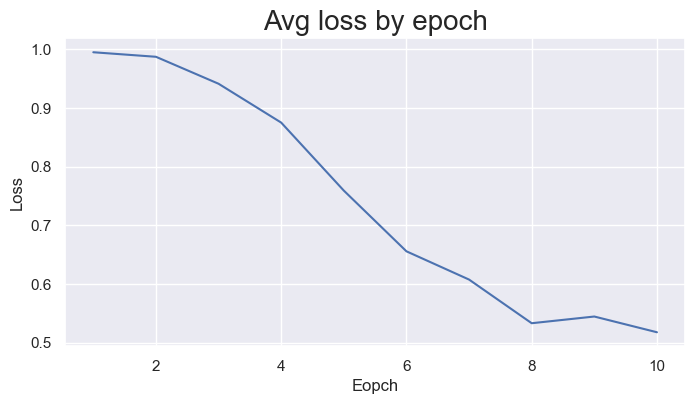

In [44]:
w1, b1, w2, b2, w_out, b_out, loss = train_ANN(xtrain, ytrain)

#### Testing Module

In [45]:
def ANN_pred(xtest, w1, b1, w2, b2, w_out, b_out):
    pred = []

    for i in range(0, xtest.shape[0]):
        x = xtest[i]

        # Feed forword
        z1 = ReLU(np.dot(w1, x) + b1) # hidden layer 1 output
        z2 = ReLU(np.dot(w2, z1) + b2) # hidden layer 2 output
        y = Sigmoid(np.dot(w_out, z2) + b_out) # output of the output layer

        pred.append(np.heaviside(y-0.5, 1)[0])

    return np.array(pred)

In [46]:
predictions = ANN_pred(xtest, w1, b1, w2, b2, w_out, b_out)
predictions

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 0.

### Model Evaluation

In [47]:
cm = confusion_matrix(ytest, predictions)

df_cm = pd.DataFrame(cm, index = [dict_live[i] for i in range(0,2)],
                     columns = [dict_live[i] for i in range(0,2)])

In [48]:
df_cm

,Died,Survived
Died,119,49
Survived,16,84


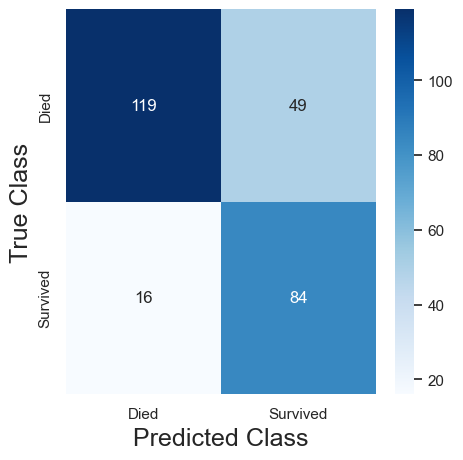

In [49]:
plt.figure(figsize=(5,5))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()

In [50]:
accuracy_score(ytest, predictions)

0.7574626865671642